# Student Details
* Guy Kabiri

# TL;DR
In this lab, we have learned to implement the `PyTorch`'s `Dataset` API and `Dataloader` which help to handle image datasets.  
As well we have implemented `Albumentations`'s compose object which creates a pipeline with probabilities that help us to create random augmentations and increase our dataset size and diversity.

# Imports

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import cv2
import albumentations as A

In [2]:
from albumentations import (
    Rotate, Blur, Flip, GaussNoise, JpegCompression, InvertImg,
    Compose, 
)
from albumentations.pytorch import ToTensor

## Import the Data

In [3]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-06 14:32:57--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-06 14:32:57--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [        <=>         ]  33.20M  21.4MB/s    in 1.6s    

2021-04-06 14:32:59 (21.4 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [4]:
train_set = torchvision.datasets.MNIST(root='', train=True, download=False)
test_set = torchvision.datasets.MNIST(root='', train=False, download=False)

# Mnist Dataset

## Dataset Class

In [5]:
class MNISTDataset(Dataset):
    def __init__(self, data, labels, transforms=None):
        super(MNISTDataset, self).__init__()

        if len(data) != len(labels):
            raise ValueError("The size of `data` and `labels` should be equals")

        self.x = data.numpy()
        self.y = labels.numpy()
        self.transforms = transforms

    def __getitem__(self, idx):
        img = self.x[idx]
        lbl = self.y[idx]

        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (224, 224))
        
        if self.transforms is not None:
            img = self.transforms(image=img)['image']
        
        # img = img[np.newaxis, :, :]
        return img, lbl

    def __len__(self):
        return len(self.x)

## Defining the Augmentations

In [6]:
transform = A.Compose([
                       Flip(            p=0.4),
                       Rotate(          p=0.2, limit=15),
                       Blur(            p=0.2, blur_limit=3),
                       GaussNoise(      p=0.5),
                       JpegCompression( p=0.4),
                       InvertImg(       p=0.3),
])

## Load the Data

In [7]:
batch_size = 50

In [8]:
test_dataset = MNISTDataset(test_set.data, test_set.targets, transform)

In [9]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Display Samples

In [10]:
test_dataloader_run = iter(test_dataloader)
img_batch, lbl_batch = next(test_dataloader_run)

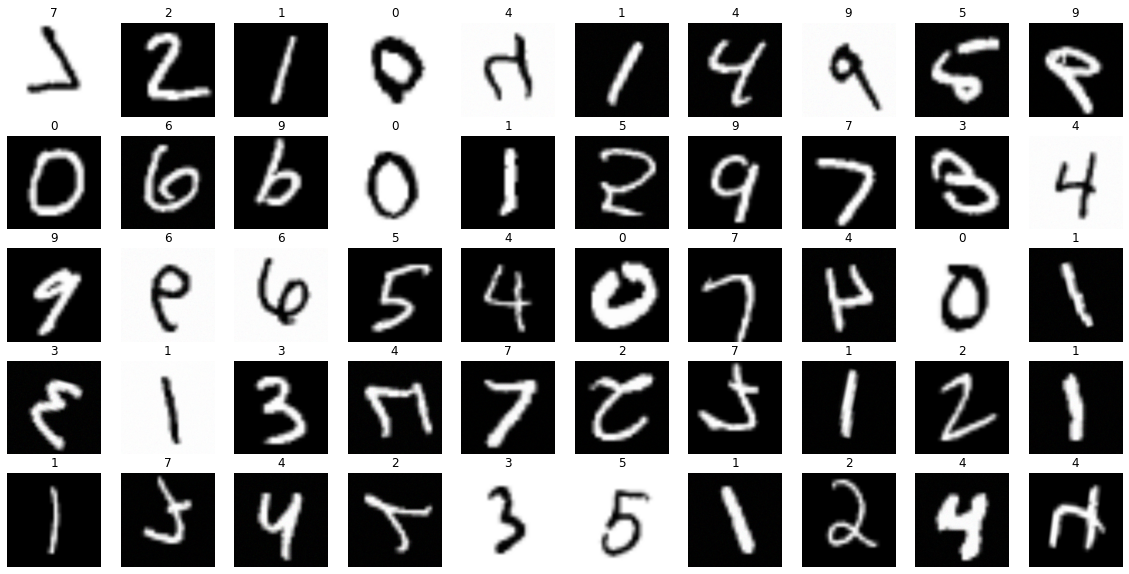

In [11]:
plt.figure(figsize=(20, 10))

for index, img, lbl in zip(range(batch_size), img_batch, lbl_batch):
    plt.subplot(5, 10, index + 1)
    # idx = random.randint(0, len(test_dataset))
    # img, lbl = test_dataset[idx]
    plt.title('{}'.format(lbl))
    plt.axis("off")
    plt.imshow(img, cmap='gray')
    
plt.show()

# AlexNet

In [12]:
data_batch = next(test_dataloader_run)[0].permute(0, 3, 1, 2)

In [13]:
alexNet = torchvision.models.alexnet(pretrained=False, num_classes=10)

In [14]:
output = alexNet(data_batch.float())

In [15]:
F.softmax(output, dim=-1).argmax(dim=-1)

tensor([4, 7, 9, 7, 1, 9, 9, 9, 4, 0, 4, 0, 3, 1, 0, 4, 4, 9, 9, 9, 4, 3, 4, 4,
        9, 4, 9, 4, 7, 4, 7, 9, 9, 9, 9, 4, 3, 2, 9, 9, 9, 9, 9, 9, 7, 2, 4, 9,
        4, 9])

# Airbus Ship Detection Dataset

## RLE Decoder

In [16]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

## Dataset Class

In [17]:
class AirebusShipDataset(Dataset):
    def __init__(self, data_path, masks, transforms=None):
        super(AirebusShipDataset, self).__init__()

        self.path = data_path
        self.x = os.listdir(data_path)
        self.y = masks
        self.transforms = transforms

    def __getitem__(self, idx):
        imgId = self.x[idx]
        img_path = self.path + '/' + imgId
        img = cv2.imread(img_path)
        msk = self.y.loc[self.y['ImageId'] == imgId, 'EncodedPixels'].tolist()
        
        all_masks = np.zeros((768, 768))
        
        if not pd.isna(msk).any():
            for mask in msk:
                all_masks += rle_decode(mask)
        
        if self.transforms is not None:
            transformed = self.transforms(image=img, mask=all_masks)
            img = transformed['image']
            all_masks = transformed['mask']
        
        # img = img[np.newaxis, :, :]
        return img, all_masks

    def __len__(self):
        return len(self.x)

In [18]:
path = '../input/airbus-ship-detection'
train_csv = pd.read_csv(path + '/train_ship_segmentations_v2.csv')
masks = pd.DataFrame(train_csv)

path_train = path + '/train_v2'
train = os.listdir(path_train)

In [25]:
airbus_dataset = AirebusShipDataset(path_train, masks)

In [31]:
batch_size = 20

In [32]:
train_dataloader = DataLoader(airbus_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [33]:
train_dataloader_run = iter(train_dataloader)

In [52]:
img_batch, msk_batch = next(train_dataloader_run)

## Display Sampels

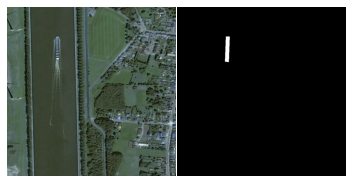

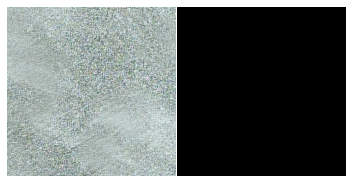

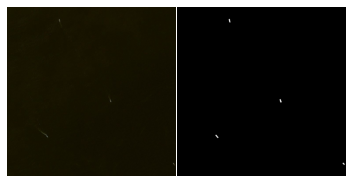

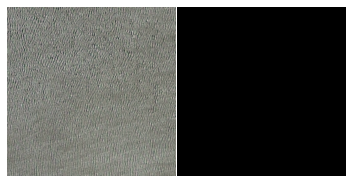

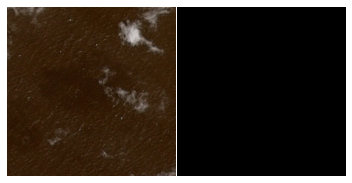

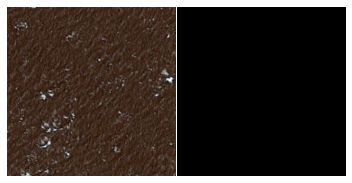

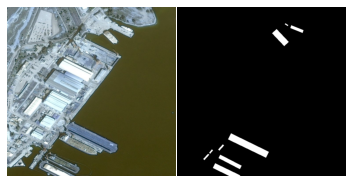

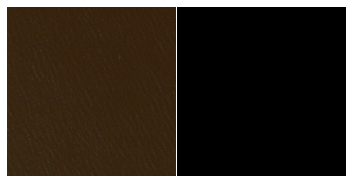

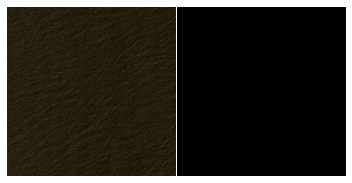

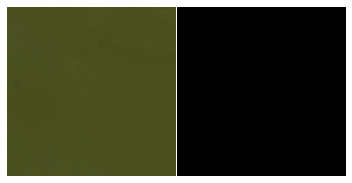

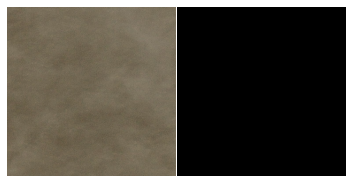

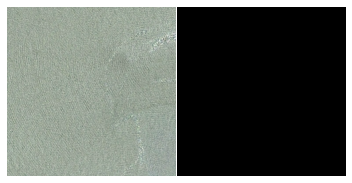

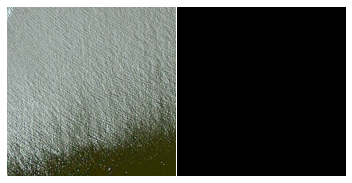

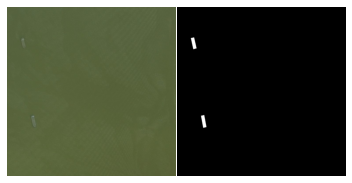

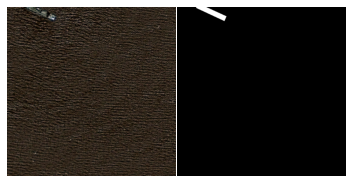

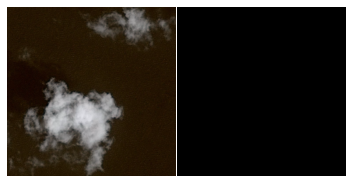

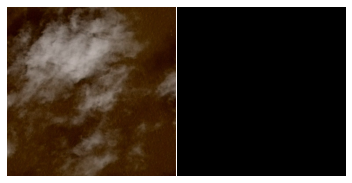

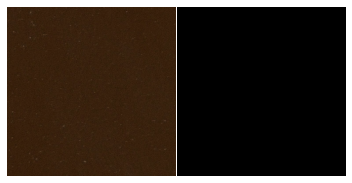

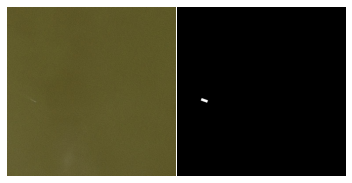

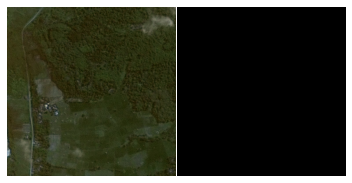

In [53]:
for index, img, msk in zip(range(batch_size), img_batch, msk_batch):
    fig, axarr = plt.subplots(1, 2, figsize=(5, 10))
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].imshow(img)
    axarr[1].imshow(msk, cmap='gray')
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()